# Test data
This notebook demonstrate the access to the test data contained in this repository.
It is a subset of the data from the isotools paper (in preparation), containing sub sampled 1\% of the reads from  chr2:214700000-216200000 and chr8:22000000-23000000. It contains two hepatocyte samples, one untreated control (CTL) and one treated with valproic acid (VPA). As this dataset is very limiting, only a subset of the functionality of isotools is demonstrated. For more extensive examples, please check the tutorials in the [documentation.](https://isotools.readthedocs.io/en/latest/tutorials.html)

In [1]:
from  isotools import Transcriptome
from isotools.plots import plot_bar, plot_distr, plot_saturation
from isotools import __version__ as isotools_version

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
logger=logging.getLogger('isotools')
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)
logger.info(f'This is isotools version {isotools_version}')


INFO:This is isotools version 0.2.8


## Import of reference annotation
The first step is to import the reference annotation from a gff or gtf file. It should be sorted and indexed with tabix. 

In [2]:
# import the reference annotation
isoseq = Transcriptome.from_reference('../tests/data/example.gff.gz')
# save the reference annotaion as pkl file (for faster access)
isoseq.save_reference('../tests/data/example_ref_isotools.pkl')
#isoseq=Transcriptome.from_reference('../tests/data/example_ref_isotools.pkl')

INFO:importing reference from gff file ../tests/data/example.gff.gz
100%|█████████▉| 129k/129k [00:00<00:00, 441kB/s] 
INFO:skipped the following categories: {'CDS', 'three_prime_UTR', 'five_prime_UTR'}
INFO:saving reference to ../tests/data/example_ref_isotools.pkl


## Import of sequencing data
Next the sequencing information is added for each sample. After importing the alignments in bam format, quality control metrics are calculated, and the object with all data is stored on disk in a pickle file for later use.

In [3]:
# import the isoseq data
for sa in ('CTL', 'VPA'):
    isoseq.add_sample_from_bam(f'../tests/data/example_1_{sa}.bam', sample_name=sa, group=sa, platform='SequelII')
# save the imported file as pkl file (for faster import)
isoseq.add_qc_metrics('../tests/data/example.fa')
isoseq.save('../tests/data/example_1_isotools.pkl')
# later we can restore the data with isoseq=Transcriptome.load("filename.pkl")

INFO:adding sample CTL from file ../tests/data/example_1_CTL.bam
100%|██████████| 678/678 [00:00<00:00, 1.22kreads/s, chr=chr8_part]
INFO:ignoring 7 chimeric alignments with less than 2 reads
INFO:imported 671 nonchimeric reads.
INFO:adding sample VPA from file ../tests/data/example_1_VPA.bam
100%|██████████| 298/298 [00:00<00:00, 1.26kreads/s, chr=chr8_part]
INFO:skipped 1 reads aligned fraction of less than 0.75.
INFO:ignoring 3 chimeric alignments with less than 2 reads
INFO:imported 294 nonchimeric reads.
100%|██████████| 68/68 [00:00<00:00, 298.70genes/s]
INFO:saving transcriptome to ../tests/data/example_1_isotools.pkl


## Differential splicing analysis
Next we perform differential splicing analysis. As the test dataset contains only a limited number of genes, no replicates and is subsampled to 1% of the reads, we expect only one differentially spliced event at FDR of 10%. 
The resulting table contains information on the event, involved transcripts, and the coverage in the data.

In [4]:
types_of_interest=['ES','ME','5AS','3AS']
groups=isoseq.groups()
#perform the test:
res=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index(drop=True)
sig=res.padj<.1
logger.info(f'{sum(sig)} differential splice sites in {len(res.loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')

pd.set_option('max_columns', None)
res.head(10)

INFO:testing differential splicing for CTL (1) vs VPA (1) using proportions test
100%|██████████| 68/68 [00:00<00:00, 719.54genes/s]
INFO:1 differential splice sites in 1 genes for CTL vs VPA


,gene,gene_id,chrom,strand,start,end,splice_type,novel,padj,pvalue,trA,trB,CTL_PSI,CTL_disp,VPA_PSI,VPA_disp,total_PSI,total_disp,CTL_CTL_in_cov,CTL_CTL_total_cov,VPA_VPA_in_cov,VPA_VPA_total_cov
0,SLC39A14,ENSG00000104635.15,chr8_part,+,408496,414779,ME,False,0.000009,0.000001,"[0, 3, 4, 8, 10, 13, 15, 17, 19, 23, 24, 25]","[1, 5, 6, 7, 9, 11, 16, 18, 20, 27]",0.511111,0,0.177215,0,0.387850,0,69,135,14,79
1,FN1,ENSG00000115414.21,chr2_part,-,679317,682211,ES,False,0.284609,0.081317,"[0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[3, 4, 18, 25, 26, 27, 29, 38, 39, 51, 55, 56,...",0.104255,0,0.152632,0,0.118182,0,49,470,29,190
2,FN1,ENSG00000115414.21,chr2_part,-,672015,673321,ES,False,0.540303,0.231558,"[8, 14, 20, 28, 34, 47, 49, 52, 53, 63, 70, 71...","[1, 3, 4, 6, 7, 9, 12, 13, 15, 16, 17, 19, 21,...",0.805164,0,0.846591,0,0.817276,0,343,426,149,176
3,FN1,ENSG00000115414.21,chr2_part,-,672300,673321,3AS,False,0.681596,0.414841,"[4, 6, 10, 12, 15, 19, 23, 25, 35, 39, 41, 43,...","[0, 1, 2, 3, 5, 7, 9, 11, 13, 16, 17, 18, 21, ...",0.736842,0,0.770186,0,0.746765,0,280,380,124,161
4,SLC39A14,ENSG00000104635.15,chr8_part,+,367408,404695,ES,True,0.681596,0.486854,"[0, 1, 2, 4, 6, 12, 13, 14, 15, 25, 26]","[3, 5, 8, 9, 10, 11, 24]",0.108527,0,0.141026,0,0.120773,0,14,129,11,78
5,FN1,ENSG00000115414.21,chr2_part,-,735654,736071,TSS,True,0.951139,0.815262,"[0, 2, 7, 9, 11, 13, 16, 17, 19, 20, 22, 23, 2...","[1, 3, 4, 5, 6, 8, 10, 12, 14, 15, 18, 21, 24,...",0.882716,0,0.876289,0,0.880882,0,429,486,170,194
6,FN1,ENSG00000115414.21,chr2_part,-,672015,673321,3AS,False,0.993990,0.993990,"[8, 14, 20, 28, 34, 47, 49, 52, 53, 63, 70, 71...","[0, 2, 5, 69, 10, 11, 42, 44, 76, 48, 18, 83, ...",0.308333,0,0.307692,0,0.308176,0,37,120,12,39


## Vizualization
Isotools provides several ways to visualize different aspects of the data. Here, we demonstrate the sashimi plots of a region of interest, in this case a exon skipping event in the FN1 gene.

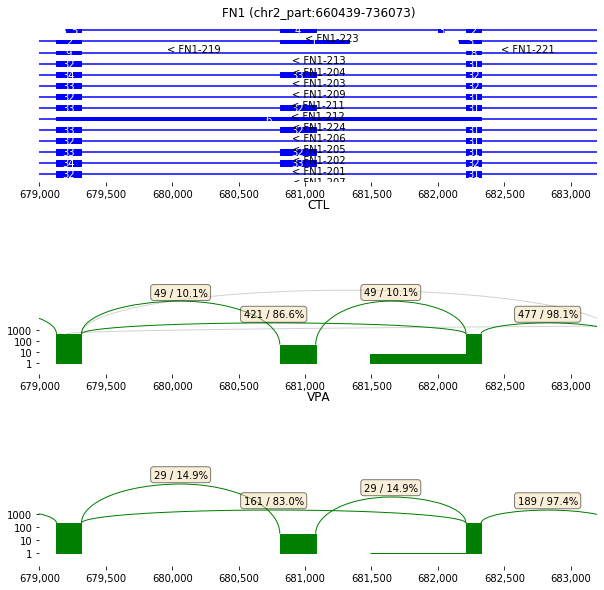

In [5]:
plt.rcParams["figure.figsize"] = (10,10)
fig, ax=isoseq['FN1'].sashimi_figure(samples=isoseq.groups(), x_range=(679000,683200))